In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"icearrows","key":"a846b1fcab121412a494477e11fae790"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d drscarlat/mimic2-original-icu
!unzip mimic2-original-icu.zip

 99% 449M/454M [00:03<00:00, 149MB/s]
100% 454M/454M [00:03<00:00, 147MB/s]
Archive:  mimic2-original-icu.zip
  inflating: MIMIC2csv/a_chartdurations.csv  
  inflating: MIMIC2csv/a_iodurations.csv  
  inflating: MIMIC2csv/a_meddurations.csv  
  inflating: MIMIC2csv/additives.csv  
  inflating: MIMIC2csv/admissions.csv  
  inflating: MIMIC2csv/censusevents.csv  
  inflating: MIMIC2csv/chartevents.csv  
  inflating: MIMIC2csv/comorbidity_scores.csv  
  inflating: MIMIC2csv/d_caregivers.csv  
  inflating: MIMIC2csv/d_careunits.csv  
  inflating: MIMIC2csv/d_chartitems.csv  
  inflating: MIMIC2csv/d_chartitems_detail.csv  
  inflating: MIMIC2csv/d_codeditems.csv  
  inflating: MIMIC2csv/d_demographicitems.csv  
  inflating: MIMIC2csv/d_ioitems.csv  
  inflating: MIMIC2csv/d_labitems.csv  
  inflating: MIMIC2csv/d_meditems.csv  
  inflating: MIMIC2csv/d_parammap_items.csv  
  inflating: MIMIC2csv/d_patients.csv  
  inflating: MIMIC2csv/db_schema.csv  
  inflating: MIMIC2csv/deliveries.csv  

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import datetime as dt

warnings.filterwarnings("ignore")

os.chdir("/content/MIMIC2csv")
file_list = os.listdir()

## 📄데이터 불러오기

In [ ]:
chartevents = pd.read_csv('chartevents.csv', keep_default_na = False)
icd9 = pd.read_csv('icd9.csv', keep_default_na = False)
admissions = pd.read_csv('admissions.csv', keep_default_na = True)
d_codeditems = pd.read_csv('d_codeditems.csv', keep_default_na = False)
drgevents = pd.read_csv('drgevents.csv', keep_default_na = False) 
patients = pd.read_csv('d_patients.csv', keep_default_na = True)

print("chart_events shape :",chartevents.shape)
print("icd9 shape :", icd9.shape)
print('admissions shape', admissions.shape)
print('d_codeditems shape', d_codeditems.shape)
print('drgevents shape', drgevents.shape)
print('patients shape', patients.shape)

chart_events shape : (34240621, 16)
icd9 shape : (53486, 5)
admissions shape (5074, 4)
d_codeditems shape (3339, 6)
drgevents shape (5055, 4)
patients shape (4000, 5)


## 🔨패혈증 찾기 및 데이터 전처리

In [ ]:
icd_9_sepis = (icd9.code == '771.81') | (icd9.code == '995.91') | (icd9.code == '995.92') | (icd9.code == '670.20') | (icd9.code == '670.22') | (icd9.code == '670.24')
icd9['issepis']=0

for i in range(len(icd9)):
  if icd9['code'][i]=='771.81':
    icd9['issepis'][i] = 1
  elif icd9['code'][i]=='995.91':
    icd9['issepis'][i] = 1
  elif icd9['code'][i]=='995.92':
    icd9['issepis'][i] = 1
  elif icd9['code'][i]=='670.20':
    icd9['issepis'][i] = 1
  elif icd9['code'][i]=='670.24':
    icd9['issepis'][i] = 1
print(icd9.shape)
icd9.loc[icd_9_sepis]

(53486, 6)


,subject_id,hadm_id,sequence,code,description,issepis
65,61,5712,8,995.91,SYST INFLAM RESPN WO/ORG \r,1
120,21,20882,11,995.92,SYST INFLAM RESPN INFECT \r,1
165,112,9111,11,995.92,SYST INFLAM RESPN INFECT \r,1
180,105,27261,9,995.91,SYSTEMIC INFLAMMATORY RESPONSE SYNDROME DUE TO...,1
280,117,14296,16,995.92,SYST INFLAM RESPN INFECT \r,1
...,...,...,...,...,...,...
53353,32529,35258,3,995.92,SYSTEMIC INFLAMMATORY RESPONSE SYNDROME DUE TO...,1
53386,32705,33462,5,995.91,SYSTEMIC INFLAMMATORY RESPONSE SYNDROME DUE TO...,1
53416,32675,35514,12,995.92,SYSTEMIC INFLAMMATORY RESPONSE SYNDROME DUE TO...,1
53443,32627,33957,4,995.92,SYSTEMIC INFLAMMATORY RESPONSE SYNDROME DUE TO...,1


 issepis라는 변수로 패혈증인 코드와 subject_id, hadm_id의 정보를 얻음

In [ ]:
drg = pd.merge(drgevents, d_codeditems, on = 'itemid')
drg = drg[['subject_id', 'hadm_id','cost_weight','itemid', 'type']]

- drgevents와 d_codeditems를 결합하므로서 환자가 지불한 cost나 어떤 아이템을 사용했는지 알 수 있음

In [ ]:
patients['dob'] = patients['dob'].apply(lambda x: dt.datetime.strptime(x,'%d/%m/%Y %H:%M:%S') if type(x)==str else pd.NaT)
patients['dod'] = patients['dod'].apply(lambda x: dt.datetime.strptime(x,'%d/%m/%Y %H:%M:%S') if type(x)==str else pd.NaT)

patients.rename(columns = {
    "hospital_expire_flg" : "is_dead"
}, inplace = True)


patients.head()

,subject_id,sex,dob,dod,is_dead
0,3,M,2606-02-28 00:00:00,2683-05-02 00:00:00,N
1,12,M,2803-05-14 00:00:00,2875-10-09 00:00:00,Y
2,21,M,3051-05-22 00:00:00,3139-03-28 00:00:00,Y
3,26,M,3007-03-02 00:00:00,3080-12-22 00:00:00,N
4,31,M,2606-05-17 00:00:00,2678-08-29 00:00:00,Y


- dob, dod 변수를 datetime으로 변경

In [ ]:
admissions['admit_dt'] = admissions['admit_dt'].apply(lambda x: dt.datetime.strptime(x,'%d/%m/%Y %H:%M:%S') if type(x)==str else pd.NaT)
admissions['disch_dt'] = admissions['disch_dt'].apply(lambda x: dt.datetime.strptime(x,'%d/%m/%Y %H:%M:%S') if type(x)==str else pd.NaT)

admissions.head()
# admit_dt : 최초 입원 시간
# disch_dt : 마지막 입원 기간

,hadm_id,subject_id,admit_dt,disch_dt
0,2,24807,3033-07-08 00:00:00,3033-07-17 00:00:00
1,3,7675,3388-05-16 00:00:00,3388-05-21 00:00:00
2,6,23547,3381-04-03 00:00:00,3381-04-22 00:00:00
3,10,14884,3015-08-28 00:00:00,3015-09-05 00:00:00
4,12,8652,3125-09-11 00:00:00,3125-09-22 00:00:00


 - admit_dt, disch_dt 변수를 datetime으로 변경

In [ ]:
pa_am = pd.merge(admissions, patients,on = "subject_id")
pa_am['first_admit_age'] = pa_am['admit_dt'] - pa_am['dob']
life_span = []

for i in range(len(pa_am)):
  if pa_am['is_dead'][i]=="Y":
    life_span.append(round((pa_am['disch_dt'][i] - pa_am['dob'][i]).days/365.24,2))
  else:
    life_span.append('')

pa_am['life_span'] = life_span
pa_am['first_admit_age'] = round(pa_am['first_admit_age'].dt.days/365.24,2)

pa_am['Age_band'] = 0
pa_am.loc[pa_am['first_admit_age']<=1,'Age_band'] = 'neonate'
pa_am.loc[(pa_am['first_admit_age']>1)&(pa_am['first_admit_age']<=13),'Age_band'] = 'adolescent'
pa_am.loc[(pa_am['first_admit_age']>=14)&(pa_am['first_admit_age']<89),'Age_band'] = 'adult'
pa_am.loc[pa_am['first_admit_age']>89,'Age_band'] = '>89'
pa_am

,hadm_id,subject_id,admit_dt,disch_dt,sex,dob,dod,is_dead,first_admit_age,life_span,Age_band
0,2,24807,3033-07-08 00:00:00,3033-07-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.63,,adult
1,1223,24807,3033-06-13 00:00:00,3033-06-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.56,,adult
2,16385,24807,3033-06-25 00:00:00,3033-06-28 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.59,,adult
3,17810,24807,3033-09-02 00:00:00,3033-09-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.78,,adult
4,17898,24807,3033-08-24 00:00:00,3033-08-30 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.76,,adult
...,...,...,...,...,...,...,...,...,...,...,...
5069,36005,29309,2541-12-11 00:00:00,2541-12-20 00:00:00,M,2457-12-11 00:00:00,2541-12-20 00:00:00,Y,84.00,84.02,adult
5070,36069,32711,3143-05-20 00:00:00,3143-05-22 00:00:00,F,3057-12-21 00:00:00,3143-05-22 00:00:00,Y,85.41,85.42,adult
5071,36071,32667,2866-02-18 00:00:00,2866-02-27 00:00:00,M,2778-01-19 00:00:00,2866-02-27 00:00:00,Y,88.08,88.11,adult
5072,36077,31134,2724-04-24 00:00:00,2724-04-27 00:00:00,F,2632-08-08 00:00:00,2724-04-27 00:00:00,Y,91.71,91.72,>89


- 위에서 datatime으로 변경된 변수들을 빼서 환자들의 나이를 측정함

In [ ]:
pa_am.groupby(['sex','Age_band']).count().T

sex                F                  M              
Age_band         >89 adult neonate  >89 adult neonate
hadm_id          286  2060      11  145  2541      18
subject_id       286  2060      11  145  2541      18
admit_dt         286  2060      11  145  2541      18
disch_dt         286  2060      11  145  2541      18
dob              286  2060      11  145  2541      18
dod              286  2060      11  145  2541      18
is_dead          286  2060      11  145  2541      18
first_admit_age  286  2060      11  145  2541      18
life_span        286  2060      11  145  2541      18

In [ ]:
pa_am = pd.merge(pa_am, icd9.loc[icd_9_sepis], on = ['subject_id', 'hadm_id'], how = 'left')
pa_am

,hadm_id,subject_id,admit_dt,disch_dt,sex,dob,dod,is_dead,first_admit_age,life_span,Age_band,sequence,code,description,issepis
0,2,24807,3033-07-08 00:00:00,3033-07-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.63,,adult,NaN,NaN,NaN,NaN
1,1223,24807,3033-06-13 00:00:00,3033-06-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.56,,adult,NaN,NaN,NaN,NaN
2,16385,24807,3033-06-25 00:00:00,3033-06-28 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.59,,adult,NaN,NaN,NaN,NaN
3,17810,24807,3033-09-02 00:00:00,3033-09-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.78,,adult,NaN,NaN,NaN,NaN
4,17898,24807,3033-08-24 00:00:00,3033-08-30 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.76,,adult,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5070,36005,29309,2541-12-11 00:00:00,2541-12-20 00:00:00,M,2457-12-11 00:00:00,2541-12-20 00:00:00,Y,84.00,84.02,adult,NaN,NaN,NaN,NaN
5071,36069,32711,3143-05-20 00:00:00,3143-05-22 00:00:00,F,3057-12-21 00:00:00,3143-05-22 00:00:00,Y,85.41,85.42,adult,NaN,NaN,NaN,NaN
5072,36071,32667,2866-02-18 00:00:00,2866-02-27 00:00:00,M,2778-01-19 00:00:00,2866-02-27 00:00:00,Y,88.08,88.11,adult,NaN,NaN,NaN,NaN
5073,36077,31134,2724-04-24 00:00:00,2724-04-27 00:00:00,F,2632-08-08 00:00:00,2724-04-27 00:00:00,Y,91.71,91.72,>89,NaN,NaN,NaN,NaN


icd9와 pa_am을 결합해서 환자들이 패혈증인지 아닌지를 판단함

In [ ]:
icustay_days = pd.read_csv('icustay_days.csv')
icustay_days['begintime'] = icustay_days['begintime'].apply(lambda x: dt.datetime.strptime(x,'%d/%m/%Y %H:%M:%S') if type(x)==str else pd.NaT)
icustay_days['endtime'] = icustay_days['endtime'].apply(lambda x: dt.datetime.strptime(x,'%d/%m/%Y %H:%M:%S') if type(x)==str else pd.NaT)
icustay_days

,icustay_id,subject_id,seq,begintime,endtime,first_day_flg,last_day_flg
0,62,56,1,2644-01-17 02:02:00,2644-01-18 02:01:59,Y,N
1,62,56,2,2644-01-18 02:02:00,2644-01-18 22:25:00,N,Y
2,41,37,1,3264-08-16 11:01:00,3264-08-17 11:00:59,Y,N
3,41,37,2,3264-08-17 11:01:00,3264-08-17 14:22:00,N,Y
4,89,78,1,2778-03-24 04:10:00,2778-03-25 04:09:59,Y,N
...,...,...,...,...,...,...,...
34823,47473,32763,28,2724-07-05 15:11:00,2724-07-06 15:10:59,N,N
34824,47473,32763,29,2724-07-06 15:11:00,2724-07-07 15:10:59,N,N
34825,47473,32763,30,2724-07-07 15:11:00,2724-07-08 15:10:59,N,N
34826,47473,32763,31,2724-07-08 15:11:00,2724-07-09 15:10:59,N,N


입원 기간을 알아내기 위해서 icustay_days를 불러오고 날짜를 datetime형식으로 바꿔줌

In [ ]:
icustay_max = icustay_days.groupby(['icustay_id','subject_id'])['endtime'].max().reset_index()
icustay_min = icustay_days.groupby(['icustay_id','subject_id'])['begintime'].min().reset_index()
icustay_diff = icustay_max[['icustay_id','subject_id']]
icustay_diff['icustay_diff'] = icustay_max['endtime']-icustay_min['begintime']
icustay_diff['icustay_diff'] = icustay_diff['icustay_diff'].dt.days
icustay_diff = pd.merge(icustay_diff, pd.read_csv('icustay_detail.csv')[['icustay_id','subject_id','hadm_id']], on = ['icustay_id', 'subject_id'])

pa_am = pd.merge(pa_am,icustay_diff, on = ['subject_id','hadm_id'])
pa_am['issepis'] = pa_am['issepis'].fillna(0)
pa_am

,hadm_id,subject_id,admit_dt,disch_dt,sex,dob,dod,is_dead,first_admit_age,life_span,Age_band,sequence,code,description,issepis,icustay_id,icustay_diff
0,2,24807,3033-07-08 00:00:00,3033-07-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.63,,adult,NaN,NaN,NaN,0.0,30800,1
1,1223,24807,3033-06-13 00:00:00,3033-06-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.56,,adult,NaN,NaN,NaN,0.0,30798,3
2,16385,24807,3033-06-25 00:00:00,3033-06-28 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.59,,adult,NaN,NaN,NaN,0.0,30799,0
3,17810,24807,3033-09-02 00:00:00,3033-09-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.78,,adult,NaN,NaN,NaN,0.0,30804,2
4,17898,24807,3033-08-24 00:00:00,3033-08-30 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.76,,adult,NaN,NaN,NaN,0.0,30802,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5380,36005,29309,2541-12-11 00:00:00,2541-12-20 00:00:00,M,2457-12-11 00:00:00,2541-12-20 00:00:00,Y,84.00,84.02,adult,NaN,NaN,NaN,0.0,43679,9
5381,36069,32711,3143-05-20 00:00:00,3143-05-22 00:00:00,F,3057-12-21 00:00:00,3143-05-22 00:00:00,Y,85.41,85.42,adult,NaN,NaN,NaN,0.0,47421,0
5382,36071,32667,2866-02-18 00:00:00,2866-02-27 00:00:00,M,2778-01-19 00:00:00,2866-02-27 00:00:00,Y,88.08,88.11,adult,NaN,NaN,NaN,0.0,47373,2
5383,36077,31134,2724-04-24 00:00:00,2724-04-27 00:00:00,F,2632-08-08 00:00:00,2724-04-27 00:00:00,Y,91.71,91.72,>89,NaN,NaN,NaN,0.0,45690,1


- 한 환자에 대한 icustay_days가 여러개 있으므로 환자에 대한 groupby를 해주고 endtime과 begintime을 서로 빼지고 icustay_diff라는 변수를 생성

## 📊통계분석

In [ ]:
d_chartitems = pd.read_csv('d_chartitems.csv')

def search_detail(df, name):
  for i in range(len(df)):
     if name in df['label'][i].lower().split():
       
      print(df['label'][i].lower().split(), df['itemid'][i])

패혈증과 관련된 item을 찾기 위해 함수를 만듬

In [ ]:
# 맥박수
search_detail(d_chartitems, 'pulse')
# 81, 188, 209, 546, 603, 1332, 1341, 1438, 1456, 1725, 1740, 1909, 2406, 2529,2530,2702,2858,3097,3124,6160,7090,7243,7925,8144
print("--"*100)

# 이완기
search_detail(d_chartitems, 'diastolic')
# 153

print("--"*100)

# 채온 관련인데...
search_detail(d_chartitems, 'temperature')
# 676, 677, 678, 679

['brachial', 'pulse', 'r/l'] 81
['femoral', 'pulse', 'r/l'] 188
['graft/flap', 'pulse'] 209
['popliteal', 'pulse', 'r/l'] 546
['radial', 'pulse', 'r/l'] 603
['pulse'] 1332
['pulse'] 1341
['ulnar', 'pulse', 'r/l'] 1438
['popliteal', 'pulse', 'r/l'] 1456
['pulse'] 1725
['r', 'rad', 'pulse'] 1740
['rt', 'le', 'pulse'] 1909
['mouth', 'flap', 'pulse'] 2406
['arterial', 'pulse', 'flap'] 2529
['venous', 'pulse'] 2530
['ulnar', 'pulse', 'right'] 2702
['rt', 'abd', 'graft', 'pulse'] 2858
['lf', 'flap', 'pulse'] 3097
['left', 'axilla', 'pulse'] 3124
['r/l', 'flap', 'pulse'] 6160
['right', 'pedal', 'pulse'] 7090
['r', 'ax', 'fem', 'bpg', 'pulse'] 7243
['thumb', 'pulse', 'checks'] 7925
['apical', 'pulse'] 8144
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
['diastolic', 'unloading'] 153
------------------------------------------------------------

교수님이 알려주심 노션 페이지를 보면 호흡률, 혈합 이런걸 분석하는 걸로 파악되고 이것을 찾으면 괜찮은 결과를 낼 수 있을듯 하다.

In [ ]:
chartevents.loc[chartevents['value1num']=='','value1num'] = -1
chartevents['value1num'] = chartevents['value1num'].astype('float')


condition_1 = (chartevents.itemid == 615) | (chartevents.itemid == 618) | (chartevents.itemid == 220210) | (chartevents.itemid == 220179)
condition_2 = (chartevents.itemid == 51) | (chartevents.itemid == 442) | (chartevents.itemid == 455) | (chartevents.itemid == 6701) | (chartevents.itemid == 220179) | (chartevents.itemid == 220050)  
condition_3 = ((chartevents.itemid == 81) | (chartevents.itemid == 188) | (chartevents.itemid == 209) | (chartevents.itemid == 546) | (chartevents.itemid == 603) | (chartevents.itemid == 1332) | (chartevents.itemid == 1341) | (chartevents.itemid == 1438) | (chartevents.itemid == 1456) |
               (chartevents.itemid == 1725) | (chartevents.itemid == 1740)| (chartevents.itemid == 1909) | (chartevents.itemid == 2406)|(chartevents.itemid == 2529)|(chartevents.itemid == 2530)|(chartevents.itemid == 2702)|(chartevents.itemid == 2858)|(chartevents.itemid == 3097) |
               (chartevents.itemid == 3124) | (chartevents.itemid == 6160) | (chartevents.itemid == 7090) | (chartevents.itemid == 7243) | (chartevents.itemid == 7925) | (chartevents.itemid == 8144))
condition_4 =  (chartevents.itemid == 676) | (chartevents.itemid == 678) 
# condition이라는 조건을 줘서 eventchart내에 있는 호흡률, 혈압, 맥박수, 체온을 추출함


con1_df = chartevents.loc[condition_1].groupby(['subject_id', 'icustay_id'])['value1num'].agg(['mean','max','min','std']).reset_index() # 환자마다 mean, max, min, std 추출
con1_df.rename(columns = {
    'mean' : 'con1_mean',
    'max' : 'con1_max',
    'min' : 'con1_min',
    'std' : 'con1_std'
},inplace = True) # 총 4번을 수행해야하므로 변수이름을 변경

con2_df = chartevents.loc[condition_2].groupby(['subject_id', 'icustay_id'])['value1num'].agg(['mean','max','min','std']).reset_index()
con2_df.rename(columns = {
    'mean' : 'con2_mean',
    'max' : 'con2_max',
    'min' : 'con2_min',
    'std' : 'con2_std'
}, inplace = True)

con3_df = chartevents.loc[condition_3].groupby(['subject_id', 'icustay_id'])['value1num'].agg(['mean','max','min','std']).reset_index()
con3_df.rename(columns = {
    'mean' : 'con3_mean',
    'max' : 'con3_max',
    'min' : 'con3_min',
    'std' : 'con3_std'
}, inplace = True)

con4_df = chartevents.loc[condition_4].groupby(['subject_id', 'icustay_id'])['value1num'].agg(['mean','max','min','std']).reset_index()
con4_df.rename(columns = {
    'mean' : 'con4_mean',
    'max' : 'con4_max',
    'min' : 'con4_min',
    'std' : 'con4_std'
}, inplace = True)

# condition_1 : 호흡률
# condition_2 : 혈압
# condition_3 : 맥박수
# condition_4 : 채온

In [ ]:
pa_am = pd.merge(pa_am, con1_df, on = ["subject_id", "icustay_id"], how = "left")
pa_am = pd.merge(pa_am, con2_df, on = ["subject_id", "icustay_id"], how = "left")
pa_am = pd.merge(pa_am, con3_df, on = ["subject_id", "icustay_id"], how = "left")
pa_am = pd.merge(pa_am, con4_df, on = ["subject_id", "icustay_id"], how = "left")
pa_am

,hadm_id,subject_id,admit_dt,disch_dt,sex,dob,dod,is_dead,first_admit_age,life_span,...,con2_min,con2_std,con3_mean,con3_max,con3_min,con3_std,con4_mean,con4_max,con4_min,con4_std
0,2,24807,3033-07-08 00:00:00,3033-07-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.63,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1223,24807,3033-06-13 00:00:00,3033-06-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.56,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16385,24807,3033-06-25 00:00:00,3033-06-28 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.59,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17810,24807,3033-09-02 00:00:00,3033-09-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.78,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17898,24807,3033-08-24 00:00:00,3033-08-30 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.76,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5380,36005,29309,2541-12-11 00:00:00,2541-12-20 00:00:00,M,2457-12-11 00:00:00,2541-12-20 00:00:00,Y,84.00,84.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5381,36069,32711,3143-05-20 00:00:00,3143-05-22 00:00:00,F,3057-12-21 00:00:00,3143-05-22 00:00:00,Y,85.41,85.42,...,71.0,9.389028,NaN,NaN,NaN,NaN,97.150002,97.500000,96.800003,0.494973
5382,36071,32667,2866-02-18 00:00:00,2866-02-27 00:00:00,M,2778-01-19 00:00:00,2866-02-27 00:00:00,Y,88.08,88.11,...,-1.0,39.468162,NaN,NaN,NaN,NaN,97.614287,98.900002,96.800003,0.779804
5383,36077,31134,2724-04-24 00:00:00,2724-04-27 00:00:00,F,2632-08-08 00:00:00,2724-04-27 00:00:00,Y,91.71,91.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- condition 1~ 4 까지 모두 합쳐주니 컬럼의 개수가 33개로 늘어났다

## 📈피크분석

In [ ]:
# condition1

from scipy.signal import find_peaks
peaks_count = []

s = 0
for i in pa_am.loc[condition_1]['subject_id'].unique():
  s+=1
  if s%20==0:
    print('con1',s)
  peaks = len(find_peaks(chartevents.loc[condition_1][chartevents['subject_id']==i]['value1num'].to_frame().reset_index()['value1num'])[0])
  peaks_count.append(peaks)

con_1peaks = pd.DataFrame(pa_am.loc[condition_1]['subject_id'].unique(), peaks_count).reset_index().rename(columns = {
    'index' : 'subject_id',
    0 : 'con1_peaks'
})

# condition1의 피크 추출

con1 20
con1 40
con1 60
con1 80
con1 100
con1 120


In [ ]:
# condition2
s = 0
peaks_count = []

for i in pa_am.loc[condition_2]['subject_id'].unique():
  s+=1
  if s%20==0:
    print('con2',s)
  peaks = len(find_peaks(chartevents.loc[condition_2][chartevents['subject_id']==i]['value1num'].to_frame().reset_index()['value1num'])[0])
  peaks_count.append(peaks)

con_2peaks = pd.DataFrame(pa_am.loc[condition_2]['subject_id'].unique(), peaks_count).reset_index().rename(columns = {
    'index' : 'subject_id',
    0 : 'con2_peaks'
})

# condition2의 피크 추출

con2 20
con2 40
con2 60
con2 80
con2 100
con2 120


In [ ]:
# # condition3

s = 0
peaks_count = []

for i in pa_am.loc[condition_3]['subject_id'].unique():
  s+=1
  if s%20==0:
    print('con3',s)
  peaks = len(find_peaks(chartevents.loc[condition_3][chartevents['subject_id']==i]['value1num'].to_frame().reset_index()['value1num'])[0])
  peaks_count.append(peaks)

con_3peaks = pd.DataFrame(pa_am.loc[condition_3]['subject_id'].unique(), peaks_count).reset_index().rename(columns = {
    'index' : 'subject_id',
    0 : 'con3_peaks'
})

# condition3의 피크 추출

In [ ]:
# condition4

s = 0
for i in pa_am.loc[condition_4]['subject_id'].unique():
  s+=1
  if s%20==0:
    print('con4',s)
  peaks = len(find_peaks(chartevents.loc[condition_4][chartevents['subject_id']==i]['value1num'].to_frame().reset_index()['value1num'])[0])
  peaks_count.append(peaks)

con_4peaks = pd.DataFrame(pa_am.loc[condition_4]['subject_id'].unique(), peaks_count).reset_index().rename(columns = {
    'index' : 'subject_id',
    0 : 'con4_peaks'
})

# condition4의 피크 추출

con4 20
con4 40
con4 60


In [ ]:
pa_am = pd.merge(pa_am, con_1peaks, on = ["subject_id"], how = "left")
pa_am = pd.merge(pa_am, con_2peaks, on = ["subject_id"], how = "left")
pa_am = pd.merge(pa_am, con_3peaks, on = ["subject_id"], how = "left")
pa_am = pd.merge(pa_am, con_4peaks, on = ["subject_id"], how = "left")
pa_am

,hadm_id,subject_id,admit_dt,disch_dt,sex,dob,dod,is_dead,first_admit_age,life_span,...,con3_min,con3_std,con4_mean,con4_max,con4_min,con4_std,con1_peaks,con2_peaks,con3_peaks,con4_peaks
0,2,24807,3033-07-08 00:00:00,3033-07-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.63,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1223,24807,3033-06-13 00:00:00,3033-06-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.56,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16385,24807,3033-06-25 00:00:00,3033-06-28 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.59,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17810,24807,3033-09-02 00:00:00,3033-09-17 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.78,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17898,24807,3033-08-24 00:00:00,3033-08-30 00:00:00,F,2992-11-20 00:00:00,3033-09-23 00:00:00,N,40.76,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5438,36005,29309,2541-12-11 00:00:00,2541-12-20 00:00:00,M,2457-12-11 00:00:00,2541-12-20 00:00:00,Y,84.00,84.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5439,36069,32711,3143-05-20 00:00:00,3143-05-22 00:00:00,F,3057-12-21 00:00:00,3143-05-22 00:00:00,Y,85.41,85.42,...,NaN,NaN,97.150002,97.500000,96.800003,0.494973,NaN,NaN,NaN,NaN
5440,36071,32667,2866-02-18 00:00:00,2866-02-27 00:00:00,M,2778-01-19 00:00:00,2866-02-27 00:00:00,Y,88.08,88.11,...,NaN,NaN,97.614287,98.900002,96.800003,0.779804,NaN,NaN,NaN,NaN
5441,36077,31134,2724-04-24 00:00:00,2724-04-27 00:00:00,F,2632-08-08 00:00:00,2724-04-27 00:00:00,Y,91.71,91.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- peak들 pa_am에 결합시킨다.


In [ ]:
pa_am = pd.merge(pa_am, drg, on = ['hadm_id','subject_id'])

demographic_detail = pd.read_csv('demographic_detail.csv')
demographic_detail = demographic_detail[['subject_id', 'hadm_id', 'admission_source_itemid', 'ethnicity_itemid']]

pa_am = pd.merge(pa_am, demographic_detail, on = ['subject_id', 'hadm_id'])

추가적인 변수 추출을 위해 demographic_detail과 drg를 결합해준다.

In [ ]:
pa_am.columns

Index(['hadm_id', 'subject_id', 'admit_dt', 'disch_dt', 'sex', 'dob', 'dod',
       'is_dead', 'first_admit_age', 'life_span', 'Age_band', 'sequence',
       'code', 'description', 'issepis', 'icustay_id', 'icustay_diff',
       'con1_mean', 'con1_max', 'con1_min', 'con1_std', 'con2_mean',
       'con2_max', 'con2_min', 'con2_std', 'con3_mean', 'con3_max', 'con3_min',
       'con3_std', 'con4_mean', 'con4_max', 'con4_min', 'con4_std',
       'con1_peaks', 'con2_peaks', 'con3_peaks', 'con4_peaks', 'cost_weight',
       'itemid', 'type', 'admission_source_itemid', 'ethnicity_itemid'],
      dtype='object')

In [ ]:
pa_am = pa_am.fillna(-1)
target = pa_am['issepis']
x_data = pa_am[['sex', 'first_admit_age', 'is_dead', 'icustay_diff', 'con1_mean', 'con1_max',
       'con1_min', 'con1_std', 'con2_mean', 'con2_max', 'con2_min', 'con2_std',
       'con3_mean', 'con3_max', 'con3_min', 'con3_std', 'con4_mean',
       'con4_max', 'con4_min', 'con4_std','con1_peaks', 'con2_peaks',
       'con3_peaks', 'con4_peaks', 'cost_weight','itemid', 'admission_source_itemid', 'ethnicity_itemid']] # 이 변수들을 학습에 사용 할 것임
       
# 밑에 건 LGBM 카테고리컬 변수 활용
"""
cat_features = ['sex', 'is_dead', 'code']
for i in enumerate(cat_features): 
  ca = i[1]
  x_data[ca] = x_data[ca].astype('category')

"""
# x_data['code'] = x_data['code'].astype('float')



# label encoding
sex_label = {'F' : 0, 'M' : 1}
x_data = x_data.replace({'sex' : sex_label})
##############################################
is_dead_label = {'Y' : 0, 'N' : 1}
x_data = x_data.replace({'is_dead' : is_dead_label})

# 정답데이터 원 데이터에서 삭제
del pa_am['issepis']

1. pa_am에 NULL값들을 다 -1로 채워준다.(NULL값들은 데이터가 없는 값이고 데이터에서 -인 경우는 없기 때문에 -1로 채움)
2. 모델에 넣을 데이터를 선정하고 다 수치형 데이터로 바꿔준다

In [ ]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5433 entries, 0 to 5432
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      5433 non-null   int64  
 1   first_admit_age          5433 non-null   float64
 2   is_dead                  5433 non-null   int64  
 3   icustay_diff             5433 non-null   int64  
 4   con1_mean                5433 non-null   float64
 5   con1_max                 5433 non-null   float64
 6   con1_min                 5433 non-null   float64
 7   con1_std                 5433 non-null   float64
 8   con2_mean                5433 non-null   float64
 9   con2_max                 5433 non-null   float64
 10  con2_min                 5433 non-null   float64
 11  con2_std                 5433 non-null   float64
 12  con3_mean                5433 non-null   float64
 13  con3_max                 5433 non-null   float64
 14  con3_min                

## ⚙ML모델링

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, target, test_size = 0.2, random_state = 123456, stratify = target)
print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)
print('x_test shape', x_test.shape)
print('y_test shape', y_test.shape)

x_train shape (4346, 28)
y_train shape (4346,)
x_test shape (1087, 28)
y_test shape (1087,)


train과 test데이터 셋 분리하고 타깃변수 y는 라벨의 분포를 그대로 쓰기위해 stratify=True로 설정

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_train_over, y_train_over = sm.fit_resample(x_train, y_train)

In [ ]:
print('x_train_over shape', x_train_over.shape)
print('y_trin_over shape', y_train_over.shape)

x_train_over shape (7486, 28)
y_trin_over shape (7486,)


In [ ]:
y_train_over.describe()
# oversampleing이 잘 된듯하다.

count    7486.000000
mean        0.500000
std         0.500033
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: issepis, dtype: float64

위에서 확인했듯이 데이터 불균형(클래스 불균형)이 심하므로 SMOTE 알고리즘을 활용해 train 셋에 클래스 불균형을 맞춰줌


** 우리가 하려는건 이진 분류이므로 y값의 평균이 0.5이면 0과 1의 클래스의 개수는 같다

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

lgbm = lgb.LGBMClassifier(random_state = 123456789)

scores = cross_val_score(lgbm, x_train, y_train, cv = 5)
print('K-Fold Average Accuarcy :',np.mean(scores))

K-Fold Average Accuarcy : 0.9042813115881646


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

clf = lgbm.fit(x_train, y_train)
pred = clf.predict(x_test)

print('Accuarcy :', accuracy_score(y_test, pred))
print('*' * 150)
print('\n','Confusion matrix','\n',confusion_matrix(y_test, pred))

Accuarcy : 0.9070837166513339
******************************************************************************************************************************************************

 Confusion matrix 
 [[905  31]
 [ 70  81]]


1. 처음 LGBM을 실행했을때는 K-Fold k=5기준 약 90.4%의 성능이 나왔다.
2. test데이터에서는 약 90.7%정도나 나왔고 confusion matrix는 1(패혈증)을 잘 못맞추는 것으로 확인되었다.

In [ ]:
!pip install optuna

from optuna.samplers import TPESampler
import optuna

sampler = TPESampler(seed = 123456)

def obj(trial):
  param = {'objective': 'binary',
          'verbose': -1,
          'metric': 'accuarcy', 
          'max_depth': trial.suggest_int('max_depth',3, 15),
          'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1e-2),
          'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
          'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
          'subsample': trial.suggest_loguniform('subsample', 0.4, 1)}

  lgbm = lgb.LGBMClassifier(**param)
  lgbm.fit(x_train, y_train)
  acc = accuracy_score(y_test ,lgbm.predict(x_test))

  return acc

study_lgb = optuna.create_study(direction = 'maximize', sampler = sampler)
study_lgb.optimize(obj, n_trials = 100)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[I 2022-06-13 11:41:50,990] A new study created in memory with name: no-name-98f1f304-a184-4c7a-b2f8-bfea3d28f789
[I 2022-06-13 11:41:54,664] Trial 0 finished with value: 0.9070837166513339 and parameters: {'max_depth': 4, 'learning_rate': 0.00794609065388648, 'n_estimators': 1151, 'min_child_samples': 19, 'subsample': 0.5649158716294}. Best is trial 0 with value: 0.9070837166513339.
[I 2022-06-13 11:42:06,386] Trial 1 finished with value: 0.8610855565777369 and parameters: {'max_depth': 7, 'learning_rate': 0.0002260109139066917, 'n_estimators': 2601, 'min_child_samples': 6, 'subsample': 0.6578878152236173}. Best is trial 0 with value: 0.9070837166513339.
[I 2022-06-13 11:42:08,530] Trial 2 finished with value: 0.8610855565777369 and parameters: {'max_depth': 7, 'learning_rate': 0.00022079563025285335, 'n_estimators': 823, 'min_child_samples': 18, 'subsample': 0.8482528816013328}. Best is trial 0 with value: 0.9070837166513339.
[I 2022-06-13 11:42:15,131] Trial 3 finished with value: 0

In [ ]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.9162833486660533,
params {'max_depth': 13, 'learning_rate': 0.009863854510035084, 'n_estimators': 2516, 'min_child_samples': 19, 'subsample': 0.5521347742722199}


In [ ]:
lgbm = lgb.LGBMClassifier(**trial_params)

lgbm.fit(x_train, y_train)
pred = lgbm.predict(x_test)
print('Accuarcy :', accuracy_score(y_test, pred))
print('*' * 150)
print('\n','Confusion matrix','\n',confusion_matrix(y_test, pred))

Accuarcy : 0.9162833486660533
******************************************************************************************************************************************************

 Confusion matrix 
 [[898  38]
 [ 53  98]]


optuna를 돌려서 최적의 하이퍼 파라메터 조합을 찾고 다시 학습을 돌림 -> 성능이 약간 상승하고 패혈증 부분을 조금 더 잘 맞출 수 있게 됨

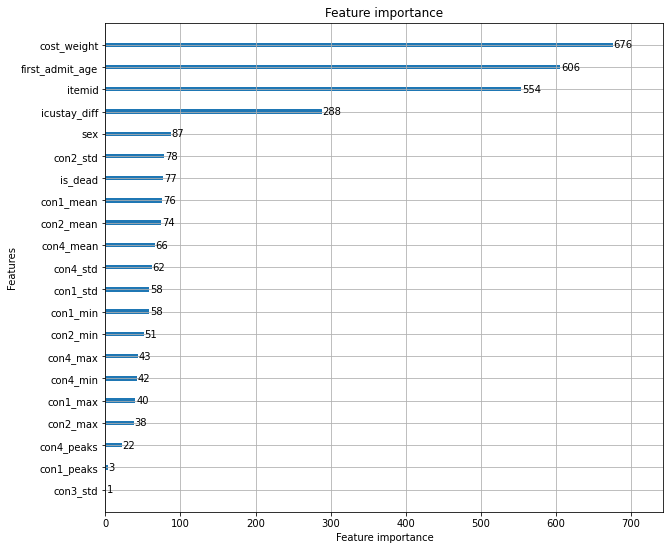

In [ ]:
from lightgbm import plot_importance 

plot_importance(clf, figsize=(10, 9));

In [ ]:
#### 참고 ####

# chartevents
# 호흡률('618', '615', '220210', '224690')
# 혈압 ( '51', '442', '455', '6701', '220179', '220050')
# 글라스고 혼수척도  ('723', '223900', '454', '223901', '184', '220739')

"""
### 피처 정의

- 인구통계
    - 연령, 성별, 인종
- 입원패턴
    - 입원기간, 중환자실 입원기간
- 진단명
    - 합병증: 30가지 주요 합병증
- 글라스고(Glasgow) 혼수척도
    - 운동/언어/눈 반응
- 바이탈사인
    - 분당맥박수, 수축기 혈압, 이완기 혈압, 호흡수, 체온 등
- 투약
    - 항생제 89종
    - 승압제
- 진단검사
    - 혈액검사, 요검사
"""

,subject_id,icustay_id,itemid,charttime,elemid,realtime,cgid,cuid,value1,value1num,value1uom,value2,value2num,value2uom,resultstatus,stopped
282,56,62,623,17/1/2644 08:00:00,0,17/1/2644 08:35:00,6251,1,Behavior Conts,-1.0,,,,,,NotStopd
447,56,62,623,17/1/2644 10:00:00,0,17/1/2644 10:04:00,6251,1,Behavior Conts,-1.0,,,,,,NotStopd
619,56,62,623,17/1/2644 13:00:00,0,17/1/2644 13:24:00,6251,1,Behavior Conts,-1.0,,,,,,NotStopd
791,56,62,623,17/1/2644 15:00:00,0,17/1/2644 17:14:00,6251,1,Behavior Conts,-1.0,,,,,,NotStopd
923,56,62,623,17/1/2644 17:00:00,0,17/1/2644 17:18:00,6251,1,Behavior Conts,-1.0,,,,,,NotStopd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34239116,32763,47473,623,8/7/2724 07:00:00,0,8/7/2724 06:59:00,8904,54,Behavior Conts,-1.0,,,,,,NotStopd
34239215,32763,47473,623,8/7/2724 09:00:00,0,8/7/2724 10:54:00,8904,54,Behavior Conts,-1.0,,,,,,NotStopd
34239328,32763,47473,623,8/7/2724 11:00:00,0,8/7/2724 10:54:00,8904,54,RestraintReapply,-1.0,,,,,,NotStopd
34239411,32763,47473,623,8/7/2724 13:00:00,0,8/7/2724 15:29:00,8904,54,RestraintReapply,-1.0,,,,,,NotStopd


## 🧠DL모델링

In [ ]:
# 위의 머신러닝에서 썼던 데이터 그대로 쓸 예정
# 사실 생데이터를 넣고싶은데 어떻게 넣어야 할지 모르겠다.(환자마다 진단, 투여받은 기록들이 다 다르다. shaep가 맞아야하는데..)
x_train

,sex,first_admit_age,is_dead,icustay_diff,con1_mean,con1_max,con1_min,con1_std,con2_mean,con2_max,...,con4_min,con4_std,con1_peaks,con2_peaks,con3_peaks,con4_peaks,cost_weight,itemid,admission_source_itemid,ethnicity_itemid
3932,1,84.10,1,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.70,60161,200029,200083
4158,1,79.35,1,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.98,60272,200029,200083
4382,1,86.78,0,14,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.97,60828,200029,200083
2272,1,84.23,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.18,60149,200029,200083
1742,1,90.08,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.70,60051,200029,200083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4970,1,80.43,0,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.80,60181,200065,200083
1156,1,76.62,1,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.84,60238,200029,200083
403,1,85.85,1,8,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.51,60316,200029,200083
1259,0,37.99,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.85,60164,200074,200083


In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
x_train_over_sc = sc.fit_transform(x_train_over)
x_test_sc = sc.transform(x_test)

print(x_train_over_sc.shape, x_test_sc.shape)

(7486, 28) (1087, 28)


딥러닝 모델링을 할 때는 Scaling을 해주면 학습에 아주좋다. 


MinMax Scaling을 해서 모든 값을 0~1로 맞춰주겠다.

In [ ]:
from tensorflow.python.keras.callbacks import History
from tensorflow.python.keras.layers import Input, Dense 
from tensorflow.python.keras.models import Model

# DNN모델 설계
def dnn(units, x_train):
  inputs = Input(shape = (x_train.shape[1],))
  hidden1 = Dense(units = units*2, activation = 'relu')(inputs)
  hidden2 = Dense(units = units, activation = 'relu')(hidden1)
  hidden3 = Dense(units = units//2, activation = 'relu')(hidden2)
  output = Dense(units = 1, activation = 'sigmoid')(hidden3)
  model = Model(inputs = inputs, outputs = output)
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

  return model

# fit 부분 설계
def fit_model(model,x_train, y_train, epoch, x_val,y_val):
  history = model.fit(x_train, y_train, 
                      epochs = epoch, 
                      validation_data = (x_val, y_val),
                      batch_size = 4,
                      shuffle = True)
  
  return history

# acc을 시각화
def acc_vis(history, model_name):
  f, ax = plt.subplots(figsize = (6, 3))
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.xlabel('Epochs')
  plt.ylabel('acc')
  plt.legend(['Train_acc', 'Val_acc'])
  plt.title(model_name)



In [ ]:
dnns = dnn(64, x_train_over_sc) 

dnns.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3712      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________


Hidden Layer 3개인 DNN모델을 만들었고 이진 분류이므로 

Loss는 'binary_crossentropy'를 사용,

Optimaizer는 'Adam', 

Metrics은 'Acc'사용

Hideen Layer1 의 units = 128, 2의 units = 64, 3의 units = 32

Epoch 1/100
1872/1872 [==============================] - 5s 2ms/step - loss: 0.5256 - acc: 0.7495 - val_loss: 0.5857 - val_acc: 0.6946
Epoch 2/100
1872/1872 [==============================] - 4s 2ms/step - loss: 0.4995 - acc: 0.7660 - val_loss: 0.4842 - val_acc: 0.7525
Epoch 3/100
1872/1872 [==============================] - 4s 2ms/step - loss: 0.4885 - acc: 0.7732 - val_loss: 0.6839 - val_acc: 0.6081
Epoch 4/100
1872/1872 [==============================] - 4s 2ms/step - loss: 0.4786 - acc: 0.7737 - val_loss: 0.6677 - val_acc: 0.6256
Epoch 5/100
1872/1872 [==============================] - 5s 3ms/step - loss: 0.4720 - acc: 0.7752 - val_loss: 0.5810 - val_acc: 0.6642
Epoch 6/100
1872/1872 [==============================] - 4s 2ms/step - loss: 0.4653 - acc: 0.7816 - val_loss: 0.6632 - val_acc: 0.6118
Epoch 7/100
1872/1872 [==============================] - 4s 2ms/step - loss: 0.4609 - acc: 0.7839 - val_loss: 0.5040 - val_acc: 0.7259
Epoch 8/100
1872/1872 [==============================] 

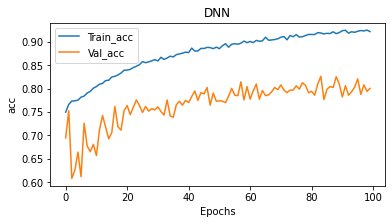

In [ ]:
models = fit_model(dnns, x_train_over_sc, y_train_over, 100, x_test_sc, y_test)
acc_vis(models, 'DNN')

DNN으로 학습을 했는데 성능이 그렇게 좋지는 않다. train_loss는 줄어드는데 val_loss는 올라가고 근데 정확도는 처음보다는 올라갔다.
  - 물론 80%선을 넘지 못하는거 같다.


In [ ]:
dnns.evaluate(x_test_sc, y_test)

34/34 [==============================] - 0s 2ms/step - loss: 1.1227 - acc: 0.8004


[1.1226919889450073, 0.8003680109977722]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

pred = dnns.predict(x_test_sc)
pred = np.transpose(pred)[0]
pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

print('Accuarcy :', accuracy_score(y_test, pred))
print('*' * 150)
print('\n','Confusion matrix','\n',confusion_matrix(y_test, pred))

Accuarcy : 0.8003679852805887
******************************************************************************************************************************************************

 Confusion matrix 
 [[788 148]
 [ 69  82]]


sigmoid 이므로 output으로 나오는 값은 각 클래스에 대한 확률값이다. 

즉, 0.5보다 높으면 1이고 낮으면 0이라는 것이다. 이것을 class에 맞게 변화시켜주고 정확도를 측정해봤다.

정확도는 약 80%가 나왔고 confusion matrix는 패혈증을 그래도 괜찮게 맞춘것 같다.

In [ ]:
!pip install pytorch_tabnet

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier(
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )
max_epochs = 100

clf.fit(
    X_train=x_train_over_sc, y_train=y_train_over,
    eval_set=[(x_train_over_sc, y_train_over), (x_test_sc, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=max_epochs , patience=20,
    batch_size=64, virtual_batch_size=64,
    num_workers=0,
    weights=1,
    drop_last=False,
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Device used : cpu
epoch 0  | loss: 0.65918 | train_accuracy: 0.70545 | valid_accuracy: 0.57314 |  0:00:07s
epoch 1  | loss: 0.53975 | train_accuracy: 0.72402 | valid_accuracy: 0.58326 |  0:00:13s
epoch 2  | loss: 0.53091 | train_accuracy: 0.74659 | valid_accuracy: 0.59982 |  0:00:20s
epoch 3  | loss: 0.52714 | train_accuracy: 0.75635 | valid_accuracy: 0.66881 |  0:00:26s
epoch 4  | loss: 0.52111 | train_accuracy: 0.73724 | valid_accuracy: 0.71389 |  0:00:31s
epoch 5  | loss: 0.51756 | train_accuracy: 0.75421 | valid_accuracy: 0.64949 |  0:00:37s
epoch 6  | loss: 0.51208 | train_accuracy: 0.7673  | valid_accuracy: 0.71757 |  0:00:39s
epoch 7  | loss: 0.51287 | train_accuracy: 0.7681  | valid_accuracy: 0.67065 |  0:00:42s
epoch 8  | loss: 0.49551 | train_accuracy: 0.77545 | valid_accuracy: 0.69457 |  0:00:44s
epoch 9  | loss: 0.50071 | train_accuracy: 0.74993 | valid_accuracy: 0.69641 |  0:

In [ ]:
preds = clf.predict(x_test_sc)
test_acc = accuracy_score(preds, y_test)
print('Accuarcy :', test_acc)
print('*' * 150)
print('\n','Confusion matrix','\n',confusion_matrix(y_test,preds))

Accuarcy : 0.8215271389144434
******************************************************************************************************************************************************

 Confusion matrix 
 [[798 138]
 [ 56  95]]


TabNet은 토치버전이 모듈로 사용가능하고 텐서플로버전은 따로 구현을 해야함


** TabNet은 Tabler데이터를 딥러닝에서 효과적으로 사용가능한 알고리즘

TabNet을 사용하고도 그렇게 성능이 좋지는 않다. 

## 🧹삽질
1. 딥러닝 모델링할때 데이터를 생으로 넣고싶어서 condition1~4까지의 itemid를 feature로 만들고 value값을 추출해봄....

 (200만 row와 16 columns)
  - 하지만 NULL값이 상상이상으로 나왔고 pa_am과 inner join했을 당시 condition1~4를 모두 가지고 있는 환자수는 300여명이었음 즉, 딥러닝 모델링을 해도 별로 쓸모 없다는 이야기(NULL값이 너무 많으므로)



2. 1의 이유로 다른 데이터에서 변수를 끌어와보려고 노력했지만..
  - 다른 변수들 역시 환자마다 길이가 다 다르고 shape을 맞추기가 쉽지않았음
  - 고정된 shape을 정의하는게 필요함
  
  (이건 시간의 따라서든, 진단이나 약물 투여 갯수로 맞추든 해서 shape을 맞춰야할 듯함, 문제는 도메인 지식이 없어서 쉽지 않음)

